<a href="https://colab.research.google.com/github/aryan-at-ul/group_project_waves_predictions/blob/main/wave_related_notebooks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install -U -q PyDrive

In [6]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [7]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [11]:
link = "https://drive.google.com/file/d/1-xJ06pAoGX6bo3b9wK9FCsONluI9MpBW/view?usp=sharing"
idd = link.split("/")[-2]
print(idd)
downloaded = drive.CreateFile({'id':idd})
print(downloaded)
downloaded.GetContentFile('bouy_data_hourly_mean.csv')

1-xJ06pAoGX6bo3b9wK9FCsONluI9MpBW
GoogleDriveFile({'id': '1-xJ06pAoGX6bo3b9wK9FCsONluI9MpBW'})


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

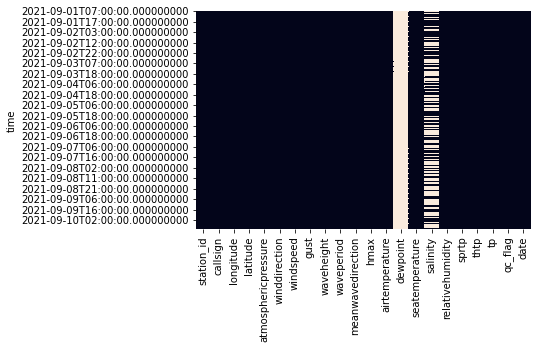

In [13]:
df = pd.read_csv("bouy_data_hourly_mean.csv",parse_dates=["time"],index_col=["time"])
df.head()
sns.heatmap(df[-1000:].isnull(), cbar=False)

In [14]:
station_names_set = set(df["station_id"])
size = df.shape[0]

# for station in station_names_set:
#     mask = df["station_id"].values == station
#     size = df.shape[0]
#     station_obs_size = mask.sum()
#     sns_plot = sns.heatmap(df[mask].isnull(), cbar=False)
#     sns_plot.figure.savefig(f"/content/output/null_spread_at_{station}_{station_obs_size}_{size}.png")

# next stuff done on m5 data as it has minimun null values 

In [15]:
df.shape

(748045, 22)

In [16]:
for station in station_names_set:
    mask = df["station_id"].values == station
    station_obs_size = mask.sum()
    print(f"null values at station : {station} , with total observation of {station_obs_size}")
    print(df[mask].isnull().sum(axis=0))
    print("===================================")

null values at station : FS1 , with total observation of 28539
station_id                 0
callsign                   0
longitude                  0
latitude                   0
atmosphericpressure      155
winddirection             68
windspeed                348
gust                   25851
waveheight               135
waveperiod               137
meanwavedirection      28538
hmax                   28539
airtemperature            59
dewpoint               28539
seatemperature         28539
salinity               28538
relativehumidity       28539
sprtp                  28539
thtp                   28539
tp                     28539
qc_flag                    0
date                       0
dtype: int64
null values at station : M2 , with total observation of 150175
station_id                  0
callsign                    0
longitude                   0
latitude                    0
atmosphericpressure      1744
winddirection           10669
windspeed               11985
gust         

In [ ]:
for station in station_names_set:
    mask = df["station_id"].values == station
    station_obs_size = mask.sum()
    df_st_series = df[mask].isnull().sum(axis=0)
    print(f"null values at station : {station} ,with observation of {station_obs_size} out of {size}")
    # print(df[mask].isnull().sum(axis=0))
    df_st_series.plot(kind='bar',title = f"null per cols for station {station}")
    plt.show()

below we try to impute missing values using cubic method, and then plot them, those fit looks logical

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Index(['atmosphericpressure', 'winddirection', 'windspeed', 'gust',
       'waveheight', 'waveperiod', 'meanwavedirection', 'hmax',
       'airtemperature', 'dewpoint', 'seatemperature', 'salinity',
       'relativehumidity'],
      dtype='object')
(131326, 13)
plotting for col:atmosphericpressure


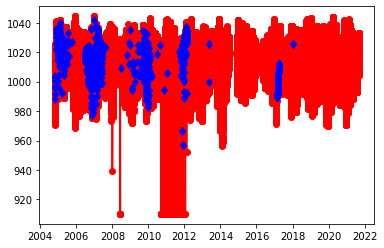

plotting for col:winddirection


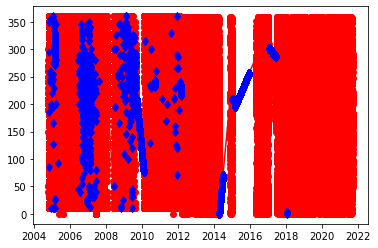

plotting for col:windspeed


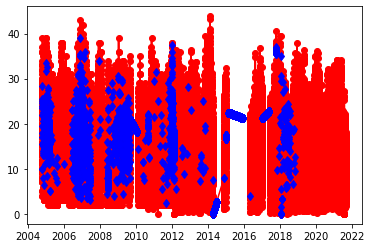

plotting for col:gust


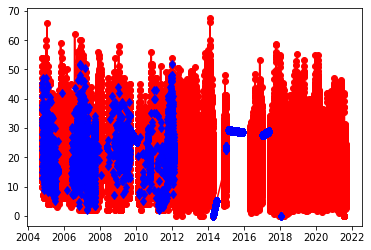

plotting for col:waveheight


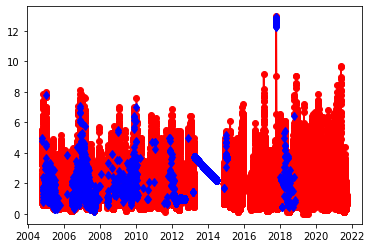

plotting for col:waveperiod


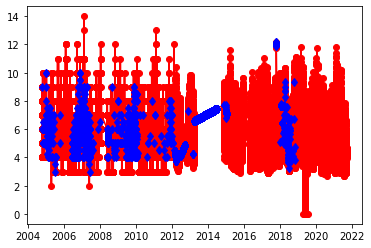

plotting for col:meanwavedirection


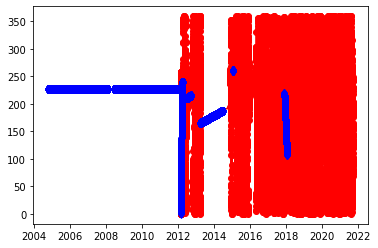

plotting for col:hmax


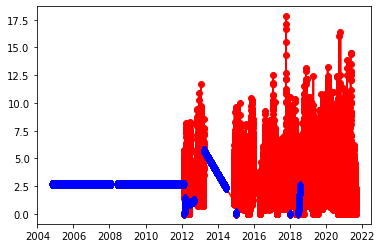

plotting for col:airtemperature


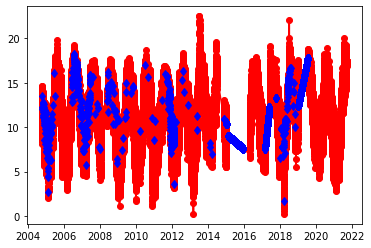

plotting for col:dewpoint


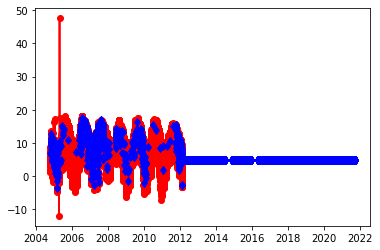

plotting for col:seatemperature


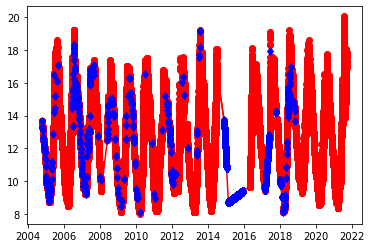

plotting for col:salinity


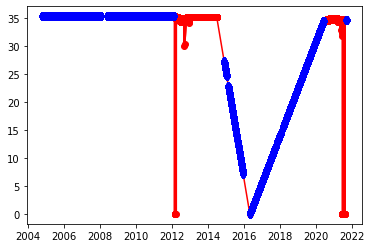

plotting for col:relativehumidity


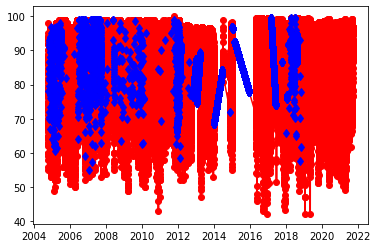

In [18]:
#pd.options.mode.chained_assignment = None
#mask = df["station_id"].values == "M5"  # could get wrong but this is fast
mask = df.loc[df.station_id == "M5" ]
df_m5 = mask#df[mask]
df_m5.drop(['date','station_id','callsign','longitude','latitude','qc_flag','tp','qc_flag','thtp','sprtp'],axis = 1, inplace=True)
print(df_m5.columns)
#df_m5 = df_m5[0:1000]
print(df_m5.shape)
null_mask = df_m5.isnull()
df_m5 = df_m5.interpolate(method="time",axis = 0).ffill().bfill()
imputed = df_m5[null_mask]
not_imputed = df_m5[~null_mask]
# ignore_cols = ['station_id','callsign','longitude','latitude','qc_flag','tp','qc_flag','thtp']
for c in df_m5.columns:
#     if c in ignore_cols:
#         continue
    print(f"plotting for col:{c}")
    plt.plot(df_m5[c],color = 'r')
    plt.plot(not_imputed[c],color = 'r', marker = 'o')
    plt.plot(imputed[c],linestyle = '',color = 'b',marker = 'd')
    plt.show()
    print("===============================")

In [19]:
from IPython.display import Math,display,HTML
import math

In [20]:
display(HTML("""<a href = "https://en.wikipedia.org/wiki/Wave_power">wave power wiki</a>"""))
display(Math("\\text{Wave power formula = } \\frac{\\rho g^2}{64 \\pi}{H_{m0}^2 T_{e}}"))

<IPython.core.display.Math object>

assuming wave height = waveheight in csv , wave period is wave period in csv , density is $$\rho = 1000kg/m^3$$ and Te being wave period 

##Not sure about units in csv file

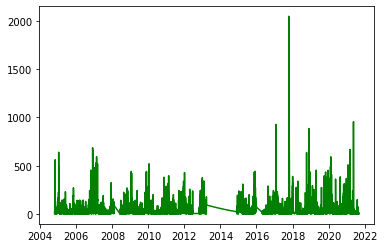

In [21]:
# adding a col that represents power at a point
def power_at_a_time(row):
    density = 1000.0
    gravity = 9.8 
    const = (density * gravity ** 2) / (64.0 * math.pi)
    power = (row['waveheight'] ** 2 ) * row['waveperiod']
    return power
#formula from wifipedia
df_m5['power'] = df_m5.apply(lambda row: power_at_a_time(row),axis = 1)
df_m5.head()
plt.plot(df_m5['power'],color = 'g')
plt.show()


In [22]:
df_m5.describe().T.style.bar(subset=['mean'],color='#205ef2').background_gradient(subset=['std'],cmap='Greens').background_gradient(subset=['50%'],cmap='Blues')

,count,mean,std,min,25%,50%,75%,max
atmosphericpressure,131326.000000,1014.631455,12.166236,910.200000,1007.400000,1016.000000,1023.000000,1044.400000
winddirection,131326.000000,203.490791,91.397644,0.000000,147.000000,220.000000,269.000000,360.000000
windspeed,131326.000000,15.185940,6.593880,0.000000,10.132000,15.000000,20.493000,43.831000
gust,131326.000000,20.576052,8.794034,0.000000,14.000000,20.037000,27.505604,67.455000
waveheight,131326.000000,1.891397,1.093953,0.000000,1.094000,1.641000,2.500000,12.969000
waveperiod,131326.000000,5.576594,1.298371,0.000000,4.570000,5.273000,6.630213,14.000000
meanwavedirection,131326.000000,214.069385,50.076508,0.000000,215.000000,226.000000,226.000000,359.000000
hmax,131326.000000,2.779448,1.273875,0.000000,2.344000,2.734000,2.734000,17.813000
airtemperature,131326.000000,11.681282,3.237960,0.229000,9.048000,11.475000,14.551000,22.480000
dewpoint,131326.000000,6.632396,3.401253,-12.100000,4.900000,4.900000,8.400000,47.600000


(131326, 14)

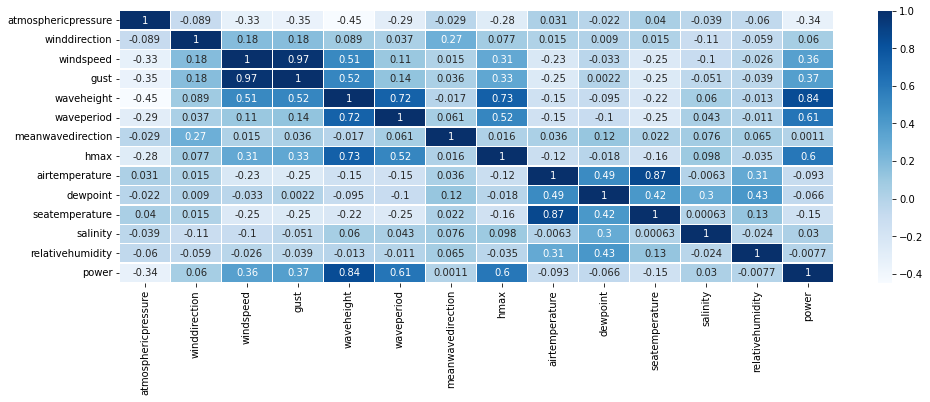

In [23]:
# some cols dont seem to have any kind of impact on power , so many in case of a multivariate model ,
# we need tp predict height and wave freq (freq can depend on wind speed etc)
corr = df_m5.corr()
plt.figure(figsize=(16,5))
sns.heatmap(corr,cmap= 'Blues',annot=True,linewidths=.5)
# useless !!!!
df_m5.shape

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


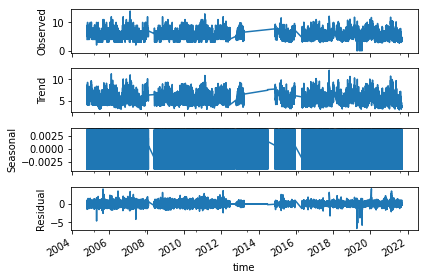

In [25]:
#analysis = df_m5[['waveheight']].copy()
decompose_result_mult = seasonal_decompose(df_m5['waveperiod'], model="additive",freq=10)
trend = decompose_result_mult.trend
seasonal = decompose_result_mult.seasonal
residual = decompose_result_mult.resid
decompose_result_mult.plot();

In [29]:
#monthly min max  # to do more on season trends etc 
# plt.figure(figsize=(10,7))
# timestep = df_m5.index.to_numpy()
# #print(timestep)
# res = df_m5.resample(rule='M').mean()
# print(res)
# timestep = res.index.to_numpy()
# vals = res['waveheight'].to_numpy()
# print(vals)

#plot_time_series(timestep,vals)
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [105]:
df_m5.shape
df_m5.columns
df_m5_copy = df_m5.copy()

df_m5_copy = df_m5_copy.resample('M').mean()
df_m5_copy = df_m5_copy.interpolate(method="time",axis = 0).ffill().bfill()
#print(df_m5_copy.isnull().sum(axis=0))
df_m5_copy.index = pd.DatetimeIndex(df_m5_copy.index).to_period('M')
train_data = df_m5_copy.iloc[:int(0.8 * len(df_m5_copy.index))-1]
#print(train_data['waveheight'].tail())
test_data = df_m5_copy.iloc[int(0.8 * len(df_m5_copy.index)):]

/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


In [90]:
model_1 = exp_smooth = ExponentialSmoothing(endog=train_data['waveheight'], 
                                  damped=True, 
                                  dates=None,
                                  freq=None,                                  
                                  missing='none', 
                                  seasonal='mul', 
                                  seasonal_periods=12, 
                                  trend='mul')
model_1_fitted = model_1.fit()

In [106]:
model_1_fitted = ExponentialSmoothing(train_data['waveheight'],trend = 'mul', seasonal='mul' , seasonal_periods = 12).fit()

In [107]:
test_predictions = model_1_fitted.forecast(40) 

In [93]:
test_predictions

2018-05    1.862155
Freq: M, dtype: float64

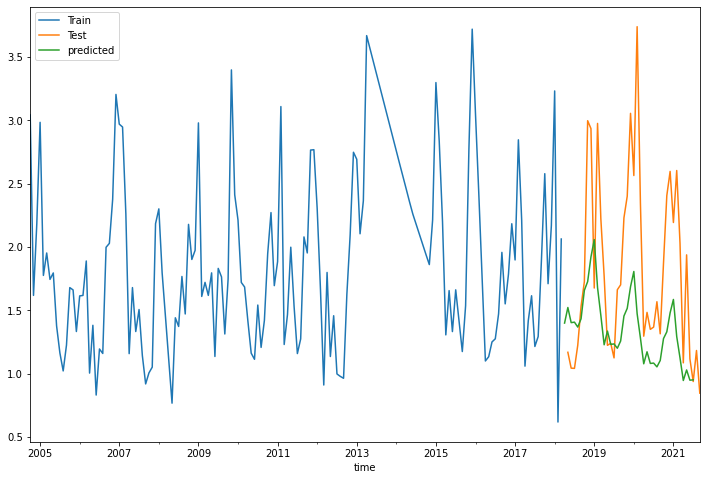

In [108]:
train_data['waveheight'].plot(legend=True,label='Train',figsize = (12,8))
test_data['waveheight'].plot(legend=True,label='Test')
test_predictions.plot(legend=True,label = 'predicted')